# 사진 묘사하기 시험 유형 만들기

사진 묘사하기 시험도 마찬가지 GPT-4-vision API는 특히 더 느리기 때문에 시험을 위한 준비를 먼저 해둬서 비싸고 재반복하는 연산은 미리 해두는게 좋음

- 사진 준비하기
- 사진에 대한 Reference 설명 만들기
- 이미지, Reference 설명을 참조하여 사용자의 설명 평가하기

In [39]:
import pandas as pd
from openai import OpenAI
from IPython.display import Image

client = OpenAI()

## create_desc 함수 만들기

In [40]:
import base64

In [41]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8') #이미지를 인코딩하여 문자열을 전송하면, openAI가 그 이미지 문자열을 decoding 하여 인식함.

In [22]:
def create_desc(img_path):
    base64_image = encode_image(img_path) #img_path라는 이미지 파일 주소를 받음.
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
              "role": "user",
              "content": [
                {"type": "text", "text": "Describe given image."},
                {
                  "type": "image_url",
                  "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}", #인코딩된 텍스트를 넣어줌.
                  },
                },
              ],
            }
            ],
            max_tokens=300
        )
    text = response.choices[0].message.content
    return text

In [6]:
!ls ./imgs

1.jpg
2.jpg
3.jpg
4.png


In [15]:
from glob import glob

In [16]:
img_list = glob("./imgs/*")

In [17]:
img_list

['./imgs\\1.jpg', './imgs\\2.jpg', './imgs\\3.jpg', './imgs\\4.png']

In [9]:
img_path = "./imgs/4.png"

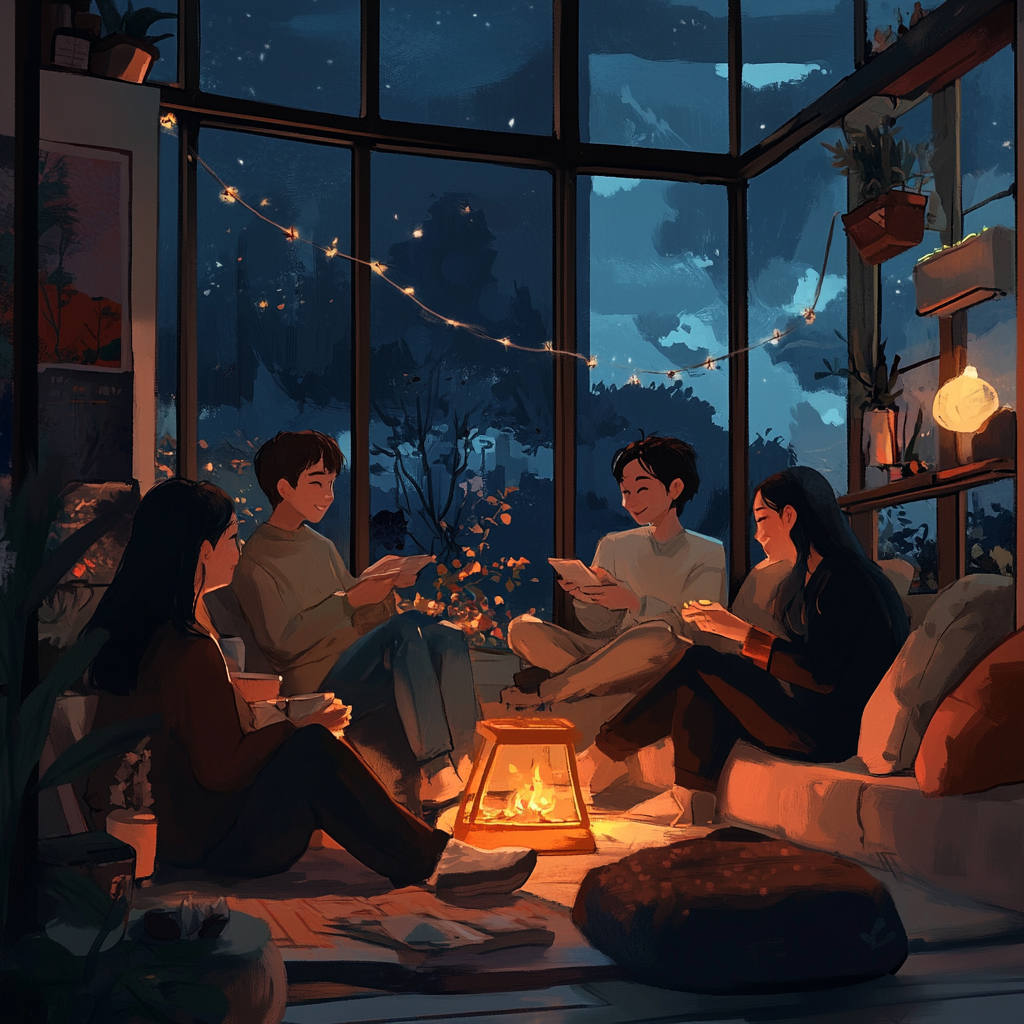

In [10]:
Image(img_path, width=480)

In [13]:
create_desc(img_path=img_path)

'주어진 이미지는 어두운 저녁 분위기의 방 안에서 네 명의 친구들이 모여 있는 장면입니다. 이들은 따뜻한 불빛 아래에 앉아 있으며, 서로 소통하며 즐거운 시간을 보내고 있습니다. 방은 큰 창문으로 되어 있어 바깥 하늘의 별과 구름을 볼 수 있습니다. 주변은 식물과 아늑한 소품들로 꾸며져 있어 아늑한 느낌을 주고 있습니다. 각 친구들은 손에 무언가를 들고 있으며, 즐거운 대화를 나누는 모습이 인상적입니다.'

## 이미지 모두 불러오기

In [26]:
from glob import glob

In [27]:
img_list = glob("./imgs/*.jpg")

In [28]:
img_list

['./imgs/2.jpg', './imgs/3.jpg', './imgs/1.jpg']

In [ ]:
#이미지를 GPT를 이용하여 설명문을 출력함.

In [23]:
record_list = []

for i, img_path in enumerate(img_list):
    desc = create_desc(img_path)
    record = {"img_path": img_path, "desc": desc}
    print(record)

    record_list.append(record)

{'img_path': './imgs\\1.jpg', 'desc': 'The image depicts a cozy family scene in a well-lit living room. A father and his daughter are lying on the floor, engaged in a drawing activity. The father, wearing glasses and a green shirt, is smiling at his daughter, who is wearing a pink top and has her hair in pigtails. They appear happy and focused on their task.\n\nIn the background, a woman is seated on a couch, casually interacting with her phone. She has long hair and is dressed in a light sweater and pants. The living room features a blue couch with colorful cushions, alongside some books stacked on the floor. The decor is modern and inviting, with plants adding a touch of greenery to the space. Overall, the scene conveys a sense of warmth and family bonding.'}
{'img_path': './imgs\\2.jpg', 'desc': 'The image depicts three individuals in a modern office setting, gathered around a laptop on a wooden table. Two women and one man are engaged in a discussion, appearing to collaborate on a 

In [19]:
!mkdir -p ./data/speaking__describe_img

명령 구문이 올바르지 않습니다.


In [20]:
save_dir = "./data/speaking__describe_img"

In [26]:
#이미지 저장주소와 이미지 설명 저장.
df = pd.DataFrame(record_list)
df

img_path                                               desc
0  ./imgs\1.jpg  The image depicts a cozy family scene in a wel...
1  ./imgs\2.jpg  The image depicts three individuals in a moder...
2  ./imgs\3.jpg  The image depicts a festive gathering, likely ...
3  ./imgs\4.png  The image depicts a cozy indoor scene at night...

In [27]:
df.to_csv(f"{save_dir}/desc_img.csv", index=False)

## 평가하기

In [28]:
from langchain_openai import ChatOpenAI
from typing import Union
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

C:\Users\msh07\miniconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.8) # CoT 는 다양한 샘플을 만들어야하기 때문에 temperature를 올려야함

In [30]:
class Evaluation(BaseModel):
    score: int = Field(description="사진 묘사하기 표현 점수. 0~10점")
    feedback: str = Field(description="사진 묘사하기를 더 잘 할 수 있도록하는 자세한 피드백. Markdown형식, 한국어로.")

In [31]:
parser = JsonOutputParser(pydantic_object=Evaluation)
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"title": "Score", "description": "사진 묘사하기 표현 점수. 0~10점", "type": "integer"}, "feedback": {"title": "Feedback", "description": "사진 묘사하기를 더 잘 할 수 있도록하는 자세한 피드백. Markdown형식, 한국어로.", "type": "string"}}, "required": ["score", "feedback"]}\n```'

In [32]:
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

human_prompt_template = HumanMessagePromptTemplate.from_template(
                            "사진 묘사하기 영어 시험이다. 사용자의 응답을 Reference와 비교하여 평가하라.\n사용자: {input}\Reference: {ref}\n{format_instructions}",
                            partial_variables={"format_instructions": format_instructions})

prompt = ChatPromptTemplate.from_messages(
    [
        human_prompt_template,
    ])

<>:4: SyntaxWarning: invalid escape sequence '\R'
<>:4: SyntaxWarning: invalid escape sequence '\R'
C:\Users\msh07\AppData\Local\Temp\ipykernel_28500\1829478573.py:4: SyntaxWarning: invalid escape sequence '\R'
  "사진 묘사하기 영어 시험이다. 사용자의 응답을 Reference와 비교하여 평가하라.\n사용자: {input}\Reference: {ref}\n{format_instructions}",


In [33]:
eval_chain = prompt | model | parser

In [34]:
sample = df.iloc[0]

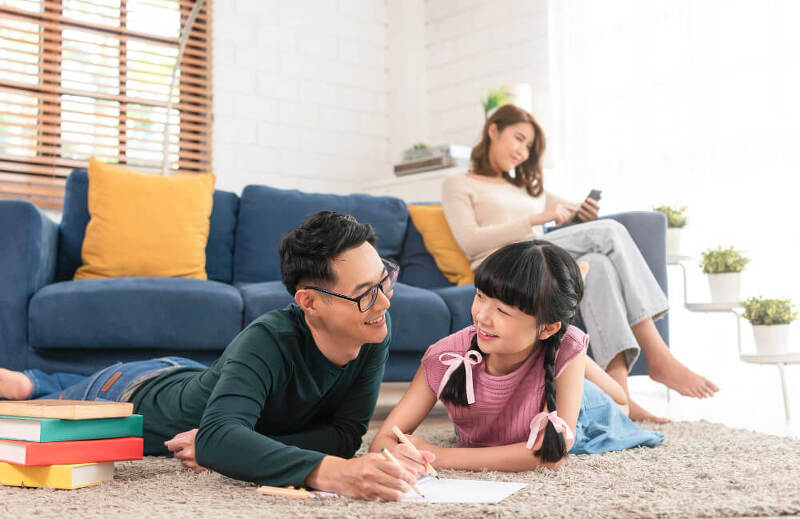

In [35]:
Image(sample['img_path'], width=480)

In [36]:
sample['desc']

'The image depicts a cozy family scene in a well-lit living room. A father and his daughter are lying on the floor, engaged in a drawing activity. The father, wearing glasses and a green shirt, is smiling at his daughter, who is wearing a pink top and has her hair in pigtails. They appear happy and focused on their task.\n\nIn the background, a woman is seated on a couch, casually interacting with her phone. She has long hair and is dressed in a light sweater and pants. The living room features a blue couch with colorful cushions, alongside some books stacked on the floor. The decor is modern and inviting, with plants adding a touch of greenery to the space. Overall, the scene conveys a sense of warmth and family bonding.'

In [37]:
result = eval_chain.invoke({"input": "There are three people in a room. a woman is sitting on a couch and a man and a girl is lying on the floor.",
                            "ref": sample['desc']})

In [38]:
result

{'score': 5,
 'feedback': '사진 묘사를 할 때 사람들의 활동이나 감정, 그리고 주변 환경에 대한 자세한 설명을 포함하는 것이 좋습니다. 예를 들어, 남자와 여자아이가 바닥에 누워 그림을 그리고 있다거나, 여성이 휴대폰을 사용하고 있다는 등의 구체적인 행동을 묘사하면 독자가 더 생생하게 상황을 이해할 수 있습니다. 또한, 인물의 복장이나 방 안의 가구, 장식품에 대한 정보도 포함시켜 방의 분위기를 전달하는 것이 좋습니다. 인물들 사이의 관계나 감정도 함께 묘사하면 사진에 대한 이해도를 높일 수 있습니다.'}